<a href="https://colab.research.google.com/github/codypape-dev/notebooks/blob/main/PML_E2_Paula_Perdomo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deterioro de la calidad de los cuerpos de agua y cómo, con el machine learning, se puede apoyar la implementación de mecanismos que permitan monitorear y evaluar las variaciones en las características fisicoquímicas del agua**

---

> ## Paula Perdomo
> #### Asignatura: Principios de Machine Learning
> #### Universidad de los Andes - Maestria en Inteligencia Artificial
> ![Universidad de los Andes](https://uniandes.edu.co/sites/default/files/logo-header.png)

---

En este ptoyecto se pretende mostrar el proceso de creacion de 2 modelos de machine learning usando los algoritmos de arboles de decision y k-vecinos mas cercanos para observar deterioro de la calidad de los cuerpos de agua y con el apoyo de estos modelos monitorear y evaluar las variaciones en las características fisicoquímicas del agua, con el fin de preservar la calidad de estos ecosistemas y garantizar la disponibilidad de agua dulce para la población humana.

### Objetivos.

- Aplicar técnicas de clasificación basadas en árboles de decisión y K-vecinos más cercanos para construir modelos predictivos que permitan estimar la calidad del agua de una zona determinada.

- Determinar cuáles son los factores que más inciden en la contaminación de los cuerpos de agua con base en los datos.


# 1. Exploración y perfilamiento de los datos

## Importacion de librerias

In [354]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, validation_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import tree

## Carga de datos

Realizaremos la carga de datos usando la función de Pandas ``read_csv()``. Se utiliza el símbolo “?” para indicar una ausencia.

In [355]:
data_raw = pd.read_csv('Datos_Etapa-2.csv', sep=',', na_values=['?'], encoding = 'utf-8')

Observamos los primeros datos del conjunto usando ``head()``

In [356]:
data_raw.head()

,pH,Dureza,Sólidos,Cloraminas,Sulfatos,Conductividad,Carbono_orgánico,Trihalometanos,Turbidez,Potabilidad
0,NaN,204.89,20791.32,7.30,368.52,564.31,10.38,86.99,2.96,NO
1,3.72,129.42,18630.06,6.64,NaN,592.89,15.18,56.33,4.50,NO
2,8.10,224.24,19909.54,9.28,NaN,418.61,16.87,66.42,3.06,NO
3,8.32,214.37,22018.42,8.06,356.89,363.27,18.44,100.34,4.63,NO
4,9.09,181.10,17978.99,6.55,310.14,398.41,11.56,32.00,4.08,NO


Observamos el comportamiento y estadisticas de interes para variables numericas

In [357]:
data_raw.describe()

,pH,Dureza,Sólidos,Cloraminas,Sulfatos,Conductividad,Carbono_orgánico,Trihalometanos,Turbidez
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000
mean,7.080804,196.369481,22014.092415,7.122241,333.775784,426.205171,14.284921,66.396281,3.966731
std,1.594369,32.879680,8768.570852,1.583143,41.416864,80.824123,3.308232,16.174983,0.780354
min,0.000000,47.430000,320.940000,0.350000,129.000000,181.480000,2.200000,0.740000,1.450000
25%,6.090000,176.847500,15666.687500,6.130000,307.695000,365.735000,12.070000,55.847500,3.440000
50%,7.040000,196.965000,20927.830000,7.130000,333.070000,421.885000,14.220000,66.620000,3.955000
75%,8.060000,216.670000,27332.760000,8.112500,359.950000,481.790000,16.560000,77.337500,4.500000
max,14.000000,323.120000,61227.200000,13.130000,481.030000,753.340000,28.300000,124.000000,6.740000


Ahora observamos el comportamiento de la variable categorica Potabilidad

In [358]:
data_raw[['Potabilidad']].apply(pd.value_counts)

,Potabilidad
NO,1998
SI,1278


In [359]:
data_raw.Potabilidad[0:10]

0    NO
1    NO
2    NO
3    NO
4    NO
5    NO
6    NO
7    NO
8    NO
9    NO
Name: Potabilidad, dtype: object

# 2. Limpieza y preparación de los datos

Comenzamos haciendo una copia de los datos en una nueva variable

In [360]:
data = data_raw.copy()

Buscamos si hay datos vacios o duplicados en el conjunto de entrenamiento.

In [361]:
data.isna().sum()

pH                  491
Dureza                0
Sólidos               0
Cloraminas            0
Sulfatos            781
Conductividad         0
Carbono_orgánico      0
Trihalometanos      162
Turbidez              0
Potabilidad           0
dtype: int64

In [362]:
data.duplicated().sum()

0

En esta ocasion en vez de eliminar los datos vacios, se utilizara SimpleImputer para asignarles el valor de la media.

In [363]:
simple_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

Dado que la variable objetivo Potabilidad es categorica, pero la libreria requiere que todas las variables sean numericas, utilizaremos un el metodo replace para convertir SI en 1 y NO en 0

In [364]:
data.Potabilidad.replace(('SI', 'NO'), (1, 0), inplace=True)

In [365]:
data.head()

,pH,Dureza,Sólidos,Cloraminas,Sulfatos,Conductividad,Carbono_orgánico,Trihalometanos,Turbidez,Potabilidad
0,NaN,204.89,20791.32,7.30,368.52,564.31,10.38,86.99,2.96,0
1,3.72,129.42,18630.06,6.64,NaN,592.89,15.18,56.33,4.50,0
2,8.10,224.24,19909.54,9.28,NaN,418.61,16.87,66.42,3.06,0
3,8.32,214.37,22018.42,8.06,356.89,363.27,18.44,100.34,4.63,0
4,9.09,181.10,17978.99,6.55,310.14,398.41,11.56,32.00,4.08,0


In [366]:
data[['Potabilidad']].apply(pd.value_counts)

,Potabilidad
0,1998
1,1278


Se crea el StandardScaler para utilizar en el pipeline aunque el algoritmo de arbol de desicion no lo requiere, pero el algoritmo KNN si para que la escala de una variable no tenga influencia sobre la clasificación.

In [367]:
scaler = StandardScaler()

Ahora creamos steps con la configuracion seleccionada para cada modelo. Para el modelo de k-vecinos mas cercanos se utiliza la estandarizacion en todas las variables numericas excepto en Potabilidad que es categorica

In [368]:
# pH	Dureza	Sólidos	Cloraminas	Sulfatos	Conductividad	Carbono_orgánico	Trihalometanos	Turbidez
numeric_features = [0, 1, 2, 3, 4, 5, 6, 7, 8]

column_transformer = ColumnTransformer(
    transformers=[
        ("num", scaler, numeric_features)
    ]
)

steps_knn = [
    ("imputer",simple_imputer),
    ("transformer",column_transformer)
]

steps_dt = [
    ("imputer",simple_imputer)
]



# 3. Construcción de un modelo de árboles de decisión

## Técnicas de validación para el ajuste de hiperparámetros

### Division y transformacion de datos
Hacemos la division de datos para train y test usando la semilla 77

In [369]:
train, test = train_test_split(data, test_size=0.2, random_state=77)
train.head()

,pH,Dureza,Sólidos,Cloraminas,Sulfatos,Conductividad,Carbono_orgánico,Trihalometanos,Turbidez,Potabilidad
3126,6.67,155.71,30610.05,8.17,337.17,425.69,15.10,79.78,4.90,1
3147,6.26,130.37,9734.68,10.28,320.36,399.35,10.85,43.42,3.93,1
2844,6.66,182.39,16828.88,7.07,355.90,434.66,16.62,69.41,3.97,1
1916,8.02,255.26,30854.83,8.76,NaN,442.50,11.09,93.27,5.32,1
1053,8.92,207.52,13291.92,8.56,357.94,468.54,15.69,107.28,4.08,0


Se realiza la separacion de la variable objetivo Potabilidad

In [370]:
x_train = train.drop(['Potabilidad'],axis=1)
y_train = train['Potabilidad']

Posteriormente, vamos a utilizar el pipeline de preprocesamiento para transformar el conjunto de datos mediante la función fit_transform()

In [371]:
pipeline = Pipeline(steps_dt)
x_train_transformed = pipeline.fit_transform(x_train)
x_train_transformed

array([[6.670000e+00, 1.557100e+02, 3.061005e+04, ..., 1.510000e+01,
        7.978000e+01, 4.900000e+00],
       [6.260000e+00, 1.303700e+02, 9.734680e+03, ..., 1.085000e+01,
        4.342000e+01, 3.930000e+00],
       [6.660000e+00, 1.823900e+02, 1.682888e+04, ..., 1.662000e+01,
        6.941000e+01, 3.970000e+00],
       ...,
       [7.500000e+00, 2.367100e+02, 2.173637e+04, ..., 2.074000e+01,
        6.831000e+01, 4.240000e+00],
       [9.650000e+00, 2.052100e+02, 8.508150e+03, ..., 1.245000e+01,
        5.390000e+01, 3.190000e+00],
       [4.870000e+00, 1.144600e+02, 3.285848e+04, ..., 1.615000e+01,
        4.565000e+01, 5.070000e+00]])

### Búsqueda de hiperparámetros
``DecisionTreeClassifier()`` será nuestro modelo base para realizar la búsqueda exhaustiva de hiperparámetros

In [372]:
decision_tree = DecisionTreeClassifier(random_state=0, class_weight='balanced')

Definimos los parametros segun lo recomendado.

In [373]:
param_grid = {'criterion':['gini', 'entropy'],
              'max_depth':[4,6,8,10,12],
              'min_samples_split':[3, 4, 5]}

Definimos ``KFold()`` para realizar la validación cruzada

In [374]:
kfold = KFold(n_splits=10, shuffle=True, random_state=0)

Definimos y ejecutamos la busqueda sobre el conjunto de entrenamiento transformado

In [375]:
grid = GridSearchCV(decision_tree, param_grid, cv=kfold, n_jobs=-1)
grid.fit(x_train_transformed, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=0),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8, 10, 12],
                         'min_samples_split': [3, 4, 5]})

Ahora almacenamos el mejor modelo y obtendremos los mejores valores de los hiperparámetros usando `grid.best_params_`:

In [376]:
print("Mejores parámetros: {}".format(grid.best_params_))

Mejores parámetros: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 3}


In [377]:
mejor_modelo_dt = grid.best_estimator_

## Evaluación del mejor modelo

Empezaremos separando la variable objetivo de las variables descriptoras en el conjunto de pruebas:

In [378]:
x_test = test.drop(['Potabilidad'],axis=1)
y_test = test['Potabilidad']

Realizamos las transformaciones sobre el conjunto de validacion

In [379]:
x_test_transformed = pipeline.transform(x_test)
x_test_transformed

array([[7.13000000e+00, 1.73690000e+02, 1.93095700e+04, ...,
        7.27000000e+00, 8.87900000e+01, 3.40000000e+00],
       [9.85000000e+00, 2.08740000e+02, 3.52892400e+04, ...,
        1.01100000e+01, 5.08900000e+01, 4.52000000e+00],
       [7.39000000e+00, 1.78340000e+02, 1.29286400e+04, ...,
        1.81100000e+01, 4.04000000e+01, 3.85000000e+00],
       ...,
       [9.16000000e+00, 2.41380000e+02, 2.81708900e+04, ...,
        8.12000000e+00, 4.82600000e+01, 3.54000000e+00],
       [6.49000000e+00, 1.72860000e+02, 1.46255600e+04, ...,
        1.02100000e+01, 5.69500000e+01, 4.67000000e+00],
       [7.09361845e+00, 1.39960000e+02, 3.14211400e+04, ...,
        1.75400000e+01, 5.48000000e+01, 4.54000000e+00]])

Realizamos las predicciones


In [380]:
y_pred = mejor_modelo_dt.predict(x_test_transformed)

Observamos las métricas de desempeño y matriz de confusion

In [381]:
print(confusion_matrix(y_test, y_pred))

[[390  13]
 [231  22]]


In [382]:
dt_cr = classification_report(y_test, y_pred, output_dict= True)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.97      0.76       403
           1       0.63      0.09      0.15       253

    accuracy                           0.63       656
   macro avg       0.63      0.53      0.46       656
weighted avg       0.63      0.63      0.53       656



Con estas metricas se puede evidenciar que los datos que tenemos no estan bien balanceados, tenemos 403 para clase **NO** y 253 para clase **SI**. Como la clase 1 no tiene tanta representación, tiene una sensibilidad y un recall bastante baja. Teniendo en cuenta lo anterior podemos afirmar que el modelo no predice bien la clase 1 o **SI**. Sin embargo **el modelo construido clasifica bien la clase 0 o NO** con un 76% de sensibilidad.

# 4. Construcción de un modelo utilizando el algoritmo K-vecinos más cercanos

## Técnicas de validación para el ajuste de hiperparámetros

### Division y transformacion de datos
Hacemos la division de datos para train y test usando la semilla 77

In [383]:
train, test = train_test_split(data, test_size=0.2, random_state=77)
train.head()

,pH,Dureza,Sólidos,Cloraminas,Sulfatos,Conductividad,Carbono_orgánico,Trihalometanos,Turbidez,Potabilidad
3126,6.67,155.71,30610.05,8.17,337.17,425.69,15.10,79.78,4.90,1
3147,6.26,130.37,9734.68,10.28,320.36,399.35,10.85,43.42,3.93,1
2844,6.66,182.39,16828.88,7.07,355.90,434.66,16.62,69.41,3.97,1
1916,8.02,255.26,30854.83,8.76,NaN,442.50,11.09,93.27,5.32,1
1053,8.92,207.52,13291.92,8.56,357.94,468.54,15.69,107.28,4.08,0


Se realiza la separacion de la variable objetivo Potabilidad

In [384]:
x_train = train.drop(['Potabilidad'],axis=1)
y_train = train['Potabilidad']

Posteriormente, vamos a utilizar el pipeline de preprocesamiento para transformar el conjunto de datos mediante la función fit_transform()

In [385]:
pipeline = Pipeline(steps_knn)
x_train_transformed = pipeline.fit_transform(x_train)
x_train_transformed

array([[-0.29106763, -1.23946047,  0.98740808, ...,  0.24874044,
         0.85824271,  1.18622635],
       [-0.57277804, -2.00306443, -1.39063232, ..., -1.04478001,
        -1.45847581, -0.04551541],
       [-0.29793861, -0.43547651, -0.58248884, ...,  0.71136422,
         0.19750643,  0.00527806],
       ...,
       [ 0.27922418,  1.20142036, -0.0234468 , ...,  1.96531816,
         0.12741869,  0.34813402],
       [ 1.75648609,  0.25218893, -1.53035382, ..., -0.5578076 ,
        -0.79073076, -0.9851947 ],
       [-1.52784504, -2.48250164,  1.24354042, ...,  0.56831608,
        -1.31638884,  1.40209862]])

### Buscar el mejor valor de k
Para este modelo intentaremos buscar el mejor valor de k, representado por el parámetro n_neighbors de KNeighborsClassifier, mediante una curva de validación. Construiremos la variable k_values usando la funcion de numpy ``linspace()`` para los valores de K: [1, 2, 3, 4, 5]

In [386]:
k_values = np.linspace(1, 5, 5, dtype='int64')
k_values

array([1, 2, 3, 4, 5])

Al ser un único hiperparámetro, vamos a utilizar la función `validation_curve()` para realizar una curva de validación con el parámetro _k_. Utilizaremos el conjunto de entrenamiento representado con las variables `x_train_transformed` y `y_train`, modificando el parámetro `n_neighbors` del modelo `KNeighborsClassifier`. Adicionalmente, utilizaremos una validación cruzada de 10 subconjuntos, almacenando los valores de exactitud en las variables `train_scores` y `val_scores`:

In [387]:
train_scores, val_scores = validation_curve(estimator=KNeighborsClassifier(),
                                            X=x_train_transformed,
                                            y=y_train,
                                            param_name='n_neighbors',
                                            param_range=k_values,
                                            scoring='accuracy',
                                            cv=10)

Para graficar estos valores, obtendremos la media y desviación estándar para los conjuntos de entrenamiento y validación generados en la validación cruzada:

In [388]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

In [389]:
print(train_mean, train_std, val_mean, val_std)

[1.         0.78324852 0.79775233 0.74215437 0.75322307] [0.         0.00277089 0.00347882 0.00241395 0.00307252] [0.58740458 0.6351145  0.60419847 0.63053435 0.61832061] [0.03294183 0.01209388 0.01916395 0.01155171 0.01790235]


Finalmente, vamos a visualizar la curva de validación utilizando `matplotlib`:

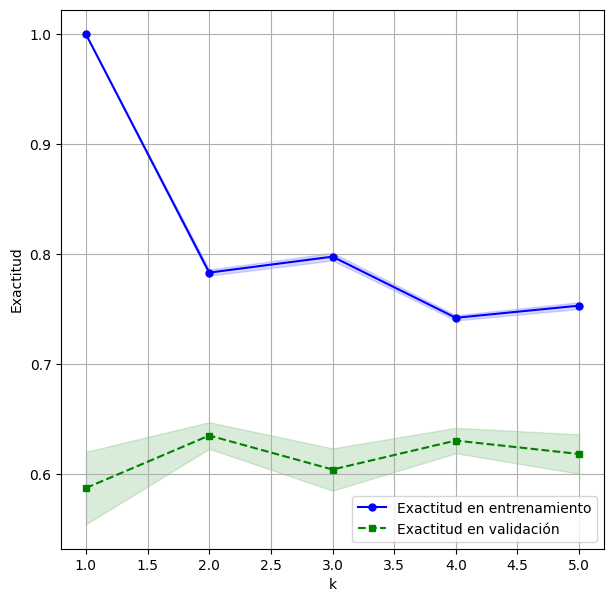

In [390]:
# Inicializamos la figura
plt.figure(figsize=(7,7))

# Creamos la curva de validación para el conjunto de entrenamiento
plt.plot(k_values, train_mean, color='blue', marker='o', markersize=5, label='Exactitud en entrenamiento')
plt.fill_between(k_values, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')

# Creamos la curva de validación para el conjunto de validación
plt.plot(k_values, val_mean, color='green', linestyle='--', marker='s', markersize=5, label='Exactitud en validación')
plt.fill_between(k_values, val_mean+val_std, val_mean-val_std, alpha=0.15, color='green')

# Agregamos una grilla y etiquetas para los ejes
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('k')
plt.ylabel('Exactitud')
plt.show()

Un posible criterio de selección del mejor valor de k es el valor de exactitud más alto en el conjunto de validación. Utilizando np.argmax() obtenemos el índice de val_mean en el que se encuentra el valor más alto:

In [391]:
mejor_indice = np.argmax(val_mean)
mejor_indice

1

Como el valor obtenido es un índice, podemos obtener el valor de _k_ obteniendo el elemento correspondiente de la lista `k_values`:

In [392]:
mejor_k = k_values[mejor_indice]
mejor_k

2

Crearemos el mejor modelo utilizando ``mejor_k``, y lo entrenaremos sobre el conjunto de entrenamiento mediante la función ``fit()``, almacenando el resultado en la variable ``mejor_modelo``:

In [393]:
mejor_modelo = KNeighborsClassifier(n_neighbors=mejor_k).fit(x_train_transformed, y_train)

## Evaluación del mejor modelo

Empezaremos separando la variable objetivo de las variables descriptoras en el conjunto de pruebas:

In [394]:
x_test = test.drop(['Potabilidad'],axis=1)
y_test = test['Potabilidad']

Realizamos las transformaciones sobre el conjunto de validacion

In [395]:
x_test_transformed = pipeline.transform(x_test)
x_test_transformed

array([[ 2.49977103e-02, -6.97645195e-01, -2.99898349e-01, ...,
        -2.13438076e+00,  1.43232506e+00, -7.18528953e-01],
       [ 1.89390580e+00,  3.58563118e-01,  1.52044308e+00, ...,
        -1.27000474e+00, -9.82516315e-01,  7.03688341e-01],
       [ 2.03643336e-01, -5.57520554e-01, -1.02678891e+00, ...,
         1.16485727e+00, -1.65089853e+00, -1.47102362e-01],
       ...,
       [ 1.41980779e+00,  1.34214769e+00,  7.09548525e-01, ...,
        -1.87567667e+00, -1.15008974e+00, -5.40751791e-01],
       [-4.14745369e-01, -7.22656690e-01, -8.33482425e-01, ...,
        -1.23956897e+00, -5.96396560e-01,  8.94163871e-01],
       [ 6.10266115e-16, -1.71407619e+00,  1.07980428e+00, ...,
         9.91373353e-01, -7.33386242e-01,  7.29085078e-01]])

Realizamos las predicciones

In [396]:
y_pred = mejor_modelo.predict(x_test_transformed)

Observamos las métricas de desempeño y matriz de confusion

In [397]:
print(confusion_matrix(y_test, y_pred))

[[362  41]
 [198  55]]


In [398]:
knn_cr = classification_report(y_test, y_pred, output_dict= True)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.90      0.75       403
           1       0.57      0.22      0.32       253

    accuracy                           0.64       656
   macro avg       0.61      0.56      0.53       656
weighted avg       0.62      0.64      0.58       656



Nuevamente observamos que los datos que tenemos no estan bien balanceados, tenemos 403 para clase **NO** y 253 para clase **SI**. Como la clase 1 no tiene tanta representación, tiene una sensibilidad y un recall bastante bajas. Teniendo en cuenta lo anterior podemos afirmar que el modelo no predice bien la clase 1 o **SI**. Sin embargo **el modelo construido clasifica bien la clase 0 o NO** con un 75% de sensibilidad.

# 5. Elaboración de una tabla comparativa mostrando el rendimiento sobre test de los dos modelos seleccionados

A continuacion se muestra una tabla comparativa con los resultados de los 2 modelos creados:

In [399]:
from prettytable import PrettyTable
t = PrettyTable(['Modelo','Clase', 'precision', 'recall', 'f1-score', 'accuracy'])
t.add_row(['árboles de decisión','NO', '{0:.2f}'.format(dt_cr['0']['precision']), '{0:.2f}'.format(dt_cr['0']['recall']),
           '{0:.2f}'.format(dt_cr['0']['f1-score']), '{0:.2f}'.format(dt_cr['accuracy'])])
t.add_row(['árboles de decisión','SI', '{0:.2f}'.format(dt_cr['1']['precision']), '{0:.2f}'.format(dt_cr['1']['recall']),
           '{0:.2f}'.format(dt_cr['1']['f1-score']), '{0:.2f}'.format(dt_cr['accuracy'])])
t.add_row(['K-vecinos más cercanos','NO',  '{0:.2f}'.format(knn_cr['0']['precision']), '{0:.2f}'.format(knn_cr['0']['recall']),
           '{0:.2f}'.format(knn_cr['0']['f1-score']), '{0:.2f}'.format(knn_cr['accuracy'])])
t.add_row(['K-vecinos más cercanos','SI',  '{0:.2f}'.format(knn_cr['1']['precision']), '{0:.2f}'.format(knn_cr['1']['recall']),
           '{0:.2f}'.format(knn_cr['1']['f1-score']), '{0:.2f}'.format(knn_cr['accuracy'])])
print(t)

+------------------------+-------+-----------+--------+----------+----------+
|         Modelo         | Clase | precision | recall | f1-score | accuracy |
+------------------------+-------+-----------+--------+----------+----------+
|  árboles de decisión   |   NO  |    0.63   |  0.97  |   0.76   |   0.63   |
|  árboles de decisión   |   SI  |    0.63   |  0.09  |   0.15   |   0.63   |
| K-vecinos más cercanos |   NO  |    0.65   |  0.90  |   0.75   |   0.64   |
| K-vecinos más cercanos |   SI  |    0.57   |  0.22  |   0.32   |   0.64   |
+------------------------+-------+-----------+--------+----------+----------+



Por la poca representacion de la clase SI en el conjunto de datos, ambos modelos tienen baja sensibilidad y recall para esta clase. Sin embargo **si se va a utilizar uno de los modelos construidos para predecir con un alto recall sobre la clase NO**, entonces se recomendaria usar **el modelo de árboles de decisión pues tiene un recall mas alto**, osea que predice correctamente esta clase en un mayor porcentage.

# 6.  Reglas que indican cuándo el agua no es apta para el consumo humano

In [400]:
importancia = mejor_modelo_dt.feature_importances_
importancia

array([0.18777224, 0.19517116, 0.11498833, 0.        , 0.35294457,
       0.        , 0.10367299, 0.        , 0.04545071])

In [401]:
importancia_df = pd.DataFrame(data={'Variable':x_train.columns, 'Importancia':importancia})
importancia_df.sort_values('Importancia', ascending=False)

,Variable,Importancia
4,Sulfatos,0.352945
1,Dureza,0.195171
0,pH,0.187772
2,Sólidos,0.114988
6,Carbono_orgánico,0.103673
8,Turbidez,0.045451
3,Cloraminas,0.000000
5,Conductividad,0.000000
7,Trihalometanos,0.000000


Podemos observar que la variable con mayor importancia es **Sulfatos**. Tambien se puede evidenciar que las variables Cloraminas, Conductividad y Trihalometanos no son de importancia para la prediccion usando este modelo.

Ahora construiremos una grafica para visualizar el árbol

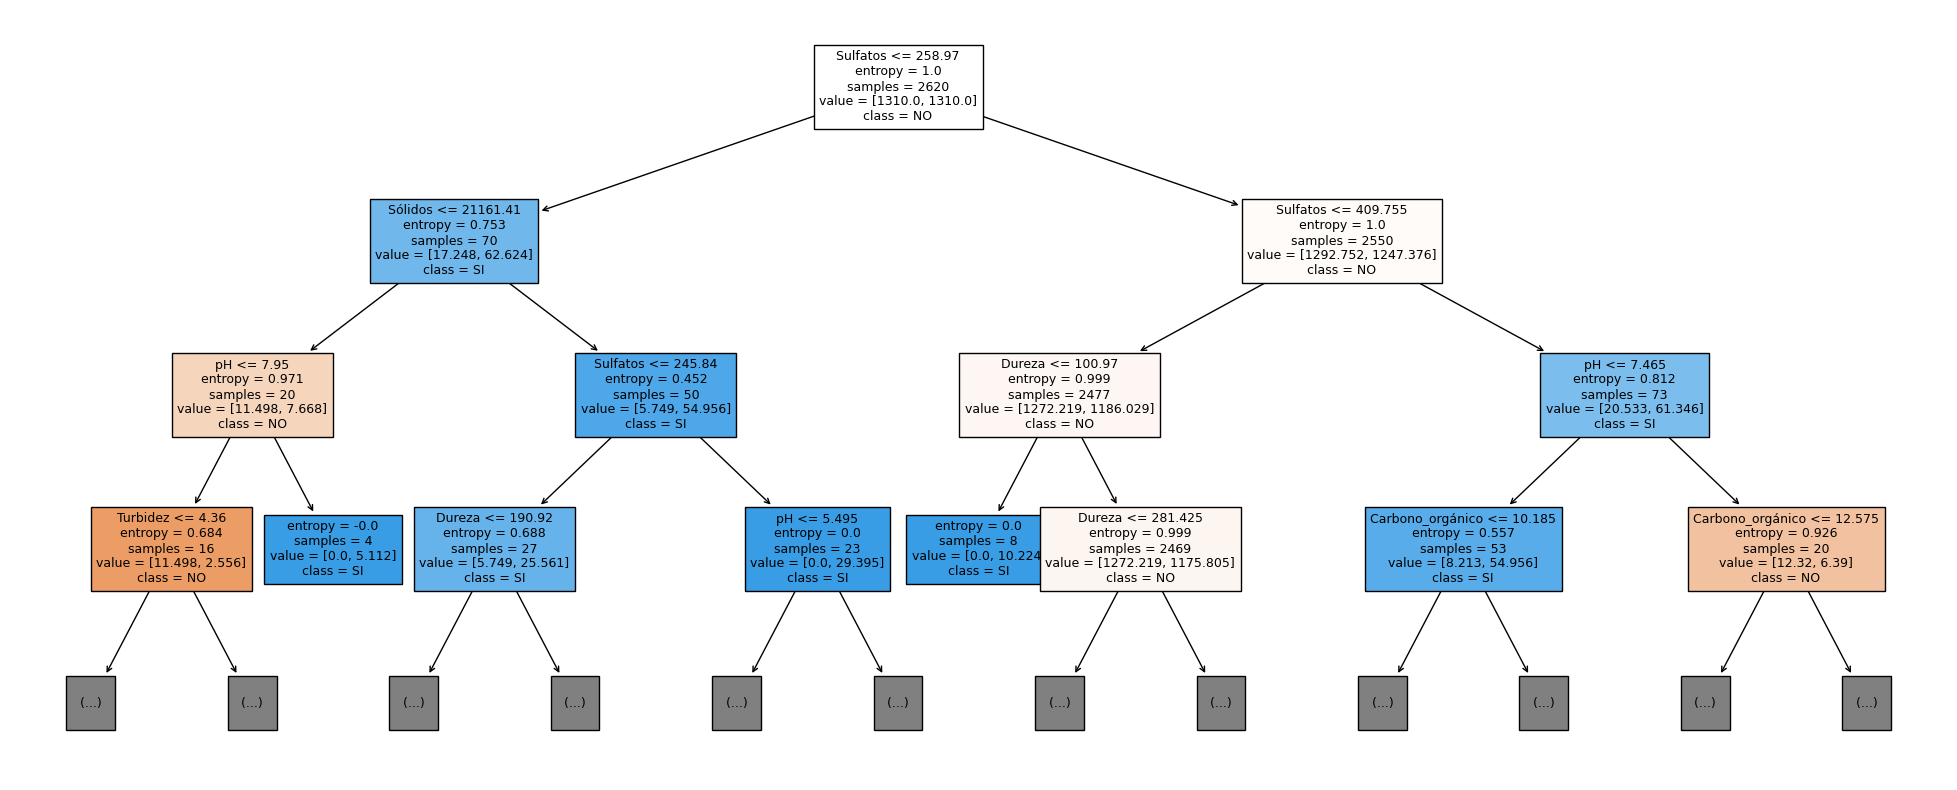

In [402]:
plt.figure(figsize=(25,10))
tree_plt = plot_tree(mejor_modelo_dt, max_depth=3, feature_names=importancia_df['Variable'], class_names=['NO','SI'], filled=True, fontsize=9)

Podemos construir las reglas para determinar cuando el agua no es apta para el consumo humano con ayuda de la funcion ``export_text()``:


In [403]:
text_representation = tree.export_text(mejor_modelo_dt, max_depth=3, feature_names=['pH','Dureza','Sólidos','Cloraminas','Sulfatos','Conductividad','Carbono_orgánico','Trihalometanos','Turbidez'])
print(text_representation)


|--- Sulfatos <= 258.97
|   |--- Sólidos <= 21161.41
|   |   |--- pH <= 7.95
|   |   |   |--- Turbidez <= 4.36
|   |   |   |   |--- class: 0
|   |   |   |--- Turbidez >  4.36
|   |   |   |   |--- class: 1
|   |   |--- pH >  7.95
|   |   |   |--- class: 1
|   |--- Sólidos >  21161.41
|   |   |--- Sulfatos <= 245.84
|   |   |   |--- Dureza <= 190.92
|   |   |   |   |--- class: 1
|   |   |   |--- Dureza >  190.92
|   |   |   |   |--- class: 1
|   |   |--- Sulfatos >  245.84
|   |   |   |--- pH <= 5.50
|   |   |   |   |--- class: 1
|   |   |   |--- pH >  5.50
|   |   |   |   |--- class: 1
|--- Sulfatos >  258.97
|   |--- Sulfatos <= 409.76
|   |   |--- Dureza <= 100.97
|   |   |   |--- class: 1
|   |   |--- Dureza >  100.97
|   |   |   |--- Dureza <= 281.42
|   |   |   |   |--- class: 0
|   |   |   |--- Dureza >  281.42
|   |   |   |   |--- class: 1
|   |--- Sulfatos >  409.76
|   |   |--- pH <= 7.46
|   |   |   |--- Carbono_orgánico <= 10.19
|   |   |   |   |--- class: 0
|   |   |   |--- 

# 7. Análisis de resultados

### ¿Qué puedes decir de los valores de las métricas recall y precisión para cada una de las clases en cada modelo? ¿Cuál de estás métricas consideras que es más importante con base en la descripción del problema?

Ambos modelos tienen un comportamiento parecido para la clase 0 o NO, donde el recall es muy alto, precision y f1 score por encima del 60%.

Por otro lado para la clase 1 o SI, ambos resultados son muy bajos, pero siendo el algoritmo de arboles de decision el peor con  recall de 0.09 y f1 score 0.15 comparado con recall de 0.22 y f1 score de 0.32 para el algoritmo de k-vecinos mas cercanos.

### ¿Consideras que el rendimiento de los modelos es adecuado? Si no es así, ¿Cómo podrían mejorarse los resultados?

Se puede observar que los datos no estan bien balanceados, pues hay mas presencia de datos para la clase "NO". Para mejorar los resultados podriamos usar varias tecnicas:
- Sobre muestreo: Aumentar el conjunto de datos de la clase minoritaria (SI) usando tecnicas como SMOTE
- Sub muestreo: Disminuir el tamaño del conjunto de datos para la clase mayoritaria (NO) mediante una selección aleatoria de un subconjunto de instancias
- Agregar pesos en el modelo para que las instancias de la clase minoritaria tengan mas valor. El algoritmo de arboles de decision tiene parametros que sirven para estos casos de datos imbalanceados.

Tambien se podria considerar realizar mas muestreos para conseguir mas datos. La desicion de como mejorar los resultados debe ser tomada por un experto.

### ¿Cuáles son las variables más significativas según el mejor modelo basado en árboles de decisión? Reflexiona sobre cómo este nuevo conocimiento podría ayudar a tomar decisiones en el contexto del problema.

Segun el modelo de arboles de desicion las variables de mas valor y su importancia son:

|Variable |	Importancia|
|------------|:-----------:|
|Sulfatos |	0.352945|
|Dureza |	0.195171|
|pH |	0.187772|
|Sólidos |	0.114988|
|Carbono_orgánico |	0.103673|
|Turbidez |	0.045451|

Teniendo en cuenta este hallazgo, se puede tomar la desicion de investigar las fuentes de agua y escoger lugares apropiados donde el agua sea naturalmente potable o encontrar tratamientos para el agua no potable que regule principalmente los niveles de sulfatos, dureza y pH que son de mayor importancia.

### Si los dos modelos proporcionan resultados similares en cuanto a las métricas de rendimiento ¿Cuál seleccionarías tomando en cuenta el contexto del problema?

Creando la matriz de confusion tenemos:

||C0 |	C1|
|------------|:-----------:|------------|
|**C0** |TP | FP|
|**C1** |FN | TN |

- C0 = No es potable
- C1 = Si es potable
- TP = No es potable clasificada como No es potable
- FP = Si es potable clasificada como No es potable
- FN = No es potable clasificada como Si es potable
- TN = Si es potable clasificada como Si es potable

Teniendo en cuenta que estamos analizando la calidad del agua para consumo humano, **lo que mas importa es que las muestras que sean no potables no se clasifiquen como potables** pues trae riesgos para la salud, es decir, evitar los falsos negativos.

Por esto lo fundamental es tener un alto recall y el modelo de arboles de desicion tiene el porcentaje mas alto con 97%.